In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

import keras
from keras.layers import Dense, Dropout, Input, LSTM, Activation, Flatten
from keras.models import Model,Sequential
from tqdm import tqdm, tqdm_notebook
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Read Datasets 
research_data_raw = pd.read_csv('Datasets/bitcoin_research_data_v2.csv')

# Drop unnecessary columns
research_data = research_data_raw.drop('Unnamed: 0', axis=1)
research_data.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,Popularity,Popularity_Normalized
0,2019-05-11,BTCUSD,6337.9,6984.8,6337.9,6793.5,9855.87,66133073.75,12.0,1200.0
1,2019-05-10,BTCUSD,6151.4,6430.0,6110.1,6337.9,9872.86,62166515.28,12.0,1200.0
2,2019-05-09,BTCUSD,5939.6,6174.0,5933.2,6151.4,7405.18,44816872.39,12.0,1200.0
3,2019-05-08,BTCUSD,5744.0,5983.2,5660.0,5939.6,6007.11,35184697.52,12.0,1200.0
4,2019-05-07,BTCUSD,5687.4,5955.8,5687.4,5906.7,3668.12,21496575.65,12.0,1200.0


In [3]:
# Set Date column as index and drop other columns that won't be used by the model
research_data = research_data.set_index('Date')
research_data.index = pd.to_datetime(research_data.index)
research_data = research_data.sort_index()
research_data = research_data.drop(['Symbol','Popularity_Normalized','Volume BTC','Volume USD'], 1)
research_data.head()

,Open,High,Low,Close,Popularity
Date,,,,,
2014-05-18,453.83,453.83,445.56,445.56,2.0
2014-05-19,445.56,445.56,445.56,445.56,2.0
2014-05-20,445.56,498.84,445.56,493.43,2.0
2014-05-21,493.43,497.67,490.85,494.77,2.0
2014-05-22,494.77,530.00,494.77,530.00,2.0


In [4]:
# Define constants
TIME_STEPS = 10
TEST_SIZE = 0.1
EPOCHS = 50
BATCH_SIZE = 4

In [5]:
# Define train_test split function
def train_test_split(df, test_size):
    splitting_point = len(df) - int(test_size * len(df))
    train_data = df.iloc[:splitting_point]
    test_data = df.iloc[splitting_point:]
    return train_data, test_data

In [6]:
# Define plot function
def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

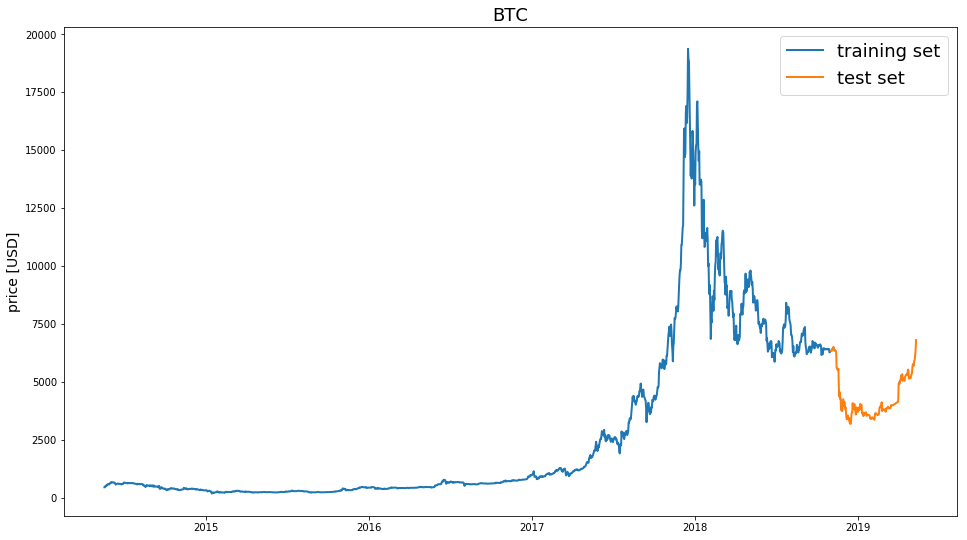

In [8]:
# Plot train and test sets
train, test = train_test_split(research_data, TEST_SIZE)
line_plot(train.Close, test.Close, 'training set', 'test set', 'BTC')

In [9]:
# Define function to normalize data with respect to first entry in the sequence. The first instance in the 
# sequence will always be zero (df / df.iloc[0] - 1) and all other instances will be relative to that first
# instance, representing the rate of change in the sequence
def get_rate_change_zero_base(df):
    return df / df.iloc[0] - 1

In [10]:
# Define function to convert dataframe into numpy array of sequences
def build_sequence(df, window_size):
    sequence_data = []
    for idx in range(len(df) - window_size):
        temp_data = df[idx: (idx + window_size)].copy()
        temp_data = get_rate_change_zero_base(temp_data)
        sequence_data.append(temp_data.values)
    return np.array(sequence_data)

In [11]:
# Define function to get training and test sets for LSTM
def get_data(df, window_size, test_size):
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract sequence from data
    X_train = build_sequence(train_data, window_size)
    X_test = build_sequence(test_data, window_size)
    
    # extract targets
    y_train = train_data.Close[window_size:].values / train_data.Close[:-window_size].values - 1
    y_test = test_data.Close[window_size:].values / test_data.Close[:-window_size].values - 1
    
    return train_data, test_data, X_train, X_test, y_train, y_test

In [12]:
# Get the proper sets for LSTM
train, test, X_train, X_test, y_train, y_test = get_data(research_data, TIME_STEPS, TEST_SIZE)

# Print set shapes
print('X_train shape: ' + str(X_train.shape))
print('y_train shape: ' + str(y_train.shape))
print('X_test shape: ' + str(X_test.shape))
print('y_test shape: ' + str(y_test.shape))

X_train shape: (1618, 10, 5)
y_train shape: (1618,)
X_test shape: (170, 10, 5)
y_test shape: (170,)


In [13]:
# Define function to create LSTM model
def create_lstm(input_data):
    lstm_model = Sequential()
    lstm_model.add(LSTM(20, input_shape=(input_data.shape[1], input_data.shape[2])))
    lstm_model.add(Dropout(0.25))
    lstm_model.add(Dense(1))
    lstm_model.add(Activation('tanh'))
    lstm_model.compile(loss='mean_absolute_error', optimizer='adam')
    return lstm_model

In [14]:
# Create model and get model summary
lstm_model = create_lstm(X_train)
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Fit model
model_results = lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/50
1618/1618 [==============================] - 4s 2ms/step - loss: 0.0521
Epoch 2/50
1618/1618 [==============================] - 3s 2ms/step - loss: 0.0387
Epoch 3/50
1618/1618 [==============================] - 3s 2ms/step - loss: 0.0360
Epoch 4/50
1618/1618 [==============================] - 5s 3ms/step - loss: 0.0343
Epoch 5/50
1618/1618 [==============================] - 3s 2ms/step - loss: 0.0339
Epoch 6/50
1618/1618 [==============================] - 3s 2ms/step - loss: 0.0313
Epoch 7/50
1618/1618 [==============================] - 3s 2ms/step - loss: 0.0324
Epoch 8/50
1618/1618 [==============================] - 3s 2ms/step - loss: 0.0319
Epoch 9/50
1618/1618 [==============================] - 3s 2ms/step - loss: 0.0316
Epoch 10/50
1618/1618 [==============================] - 3s 2ms/step - loss: 0.0312
Epoch 11/50
1618/1618 [==============================] - 3s 2ms/step - loss: 0.0308
Epoch 12/50
1618/1618 [==============================] - 3s 2ms/step - loss: 0.0301
E

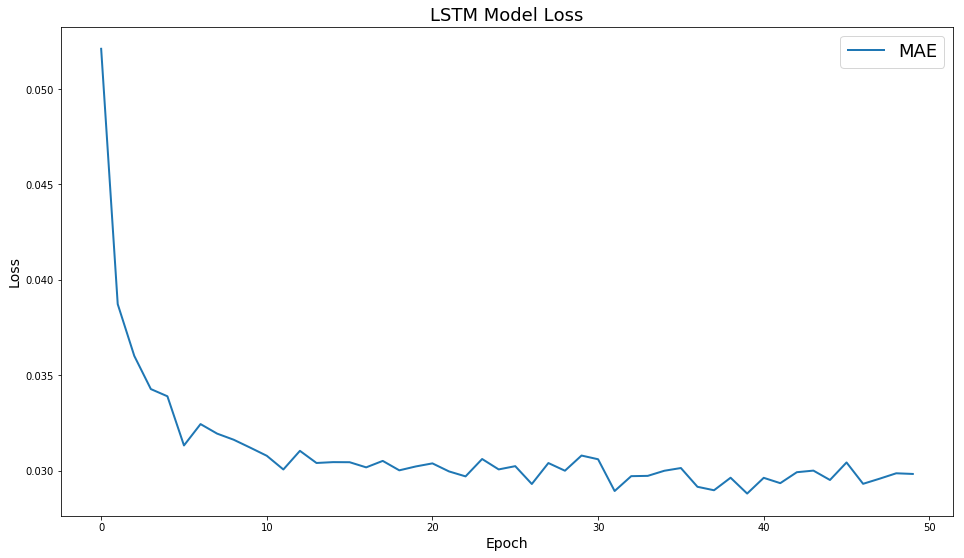

In [16]:
# Plot model loss
fig, ax = plt.subplots(1, figsize=(16, 9))
ax.plot(model_results.history['loss'], label='MAE', linewidth=2)
ax.set_ylabel('Loss', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_title('LSTM Model Loss', fontsize=18)
ax.legend(loc='best', fontsize=18)

In [17]:
# Run model against test set
predictions = lstm_model.predict(X_test).squeeze()

In [23]:
# Get the prediction metrics of the model
print("The Mean Absolute Error: %.5f" % metrics.mean_absolute_error(y_test, predictions))  
print("The Median Absolute Error: %.5f" % metrics.median_absolute_error(y_test, predictions)) 
print("The Mean Squared Error: %.5f" % metrics.mean_squared_error(y_test, predictions)) 
print("The Root Mean Squared Error: %.5f" % (np.sqrt(metrics.mean_squared_error(y_test, predictions))))

The Mean Absolute Error: 0.02448
The Median Absolute Error: 0.01283
The Mean Squared Error: 0.00145
The Root Mean Squared Error: 0.03809


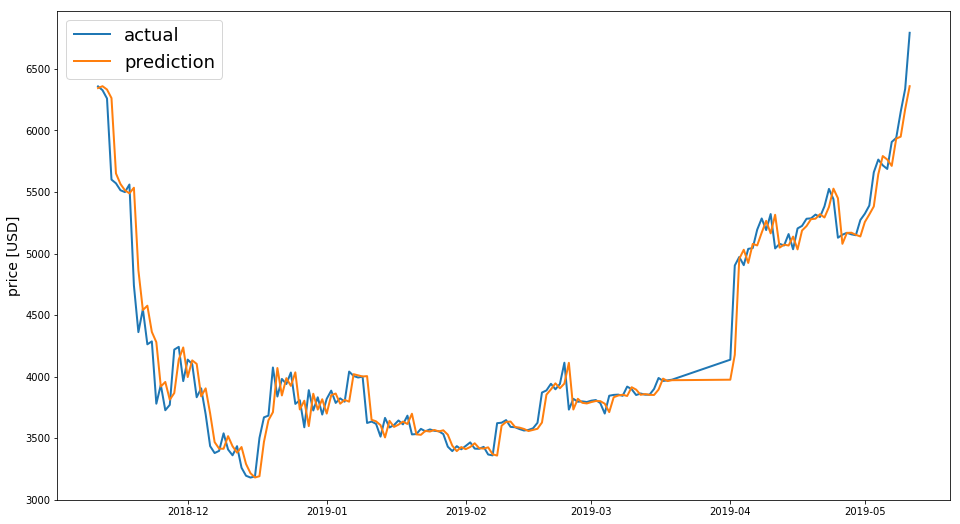

In [24]:
# Plot model predictions against actual data

# 1. Given that the final value is based on rate change, the prediction value is multiplied by the BTC price,
# which is the value previous to the defined TIME_STEPS, thus the future value is based on the formula:
# (CURR_VALUE from -TIME_STEPS days) * PREDICTED_VALUE_DENORMALIZED
# 2. Apply the same value used during the normalization for rate change calculation (df / df.iloc[0] - 1)
prediction_monetary_values = test.Close.values[:-TIME_STEPS] * (predictions + 1)
model_targets = test.Close[TIME_STEPS:]
prediction_series = pd.Series(index=model_targets.index, data=prediction_monetary_values)

line_plot(model_targets, prediction_series, 'actual', 'prediction')

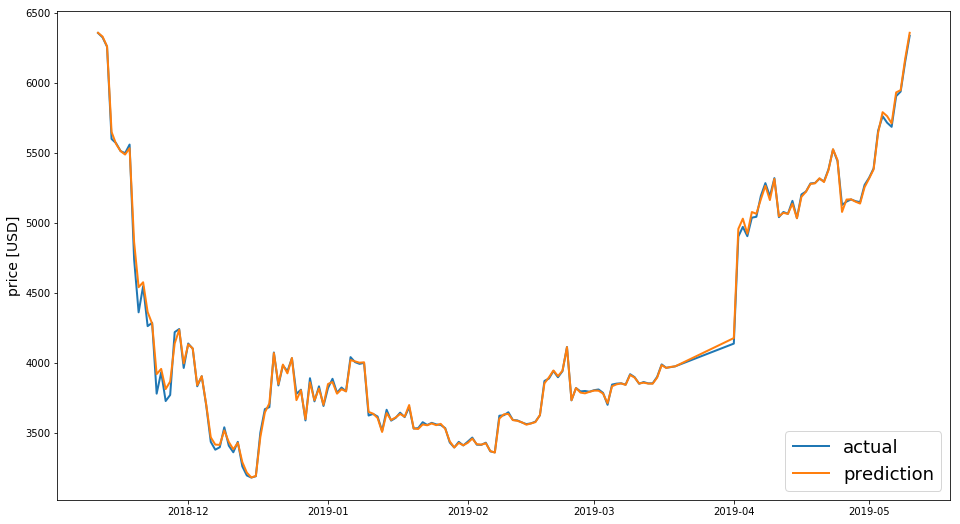

In [26]:
# Apply shift to get graphs aligned
line_plot(model_targets[:][:-1], prediction_series.shift(-1), 'actual', 'prediction')

In [29]:
# Save model

In [30]:
# Serialize model to JSON
model_json = lstm_model.to_json()
with open("Model_Files/lstm_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
lstm_model.save_weights("Model_Files/lstm_model.h5")
print("Saved model to disk")

Saved model to disk
